# Fade to Black: Predicting Run Length for Broadway Shows
## By: Justin Sullivan
### April 12, 2021

---

# Project Overview

### Project Goal

- What features are significant drivers for how long a show will run on Broadway?
- Can I develop a linerar regression model to better predict how long a Broadway show will run on Broadway?

### Key Findings

- The best **drivers** for predicting how long a show will run on Broadway are:
    - If the show is a musical
    - If the show is a play
    - The number of creative team members working on the show
    - The number of performers working on the show
    - The total number of people working on the show
<br>  
<br>
- The **baseline model** for predicting how long a show runs has an root mean square error of 367 days.
    - The baseline model is off by a year. A show closing a year before expected equates to a huge loss in expected revenue. Producers will want to reduce this error in prediction. Cast and crew members are also negatively affected by this error given that they could be out of work a year earlier than expected.
<br>  
<br>    
- I have built a **Generalized Linear Model** that **improves** upon the baseline model by 46% on out of sample data.
    - This model is better than not having a model at all! The root mean square error is 200 days for the GLM model. 
    - This means that the model is more accurate in predicting the length of time a show will run and the error is  only 6-7 months as opposed to a whole year. 
<br>  
<br>   
- With more time and data, I am confident this model can be improved upon. 

---

In [1]:
#Imports

#Python Libraries
import pandas as pd
import numpy as np

#Project Modules
import acquire
import prepare
import explore
import evaluate

#Sklearn Tools and Modules
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats

#Visualization & Formatting Tools
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate


#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Acquisition

In [2]:
#Acquire the data from local .csv using acquire module
df = acquire.get_broadway_data()

#Preview the shape of the acquired dataframe
table = [['Dataframe Name', '# of rows', '# of cols'], ['df', df.shape[0], df.shape[1]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═════════════╤═════════════╕
│ Dataframe Name   │   # of rows │   # of cols │
╞══════════════════╪═════════════╪═════════════╡
│ df               │       11053 │          29 │
╘══════════════════╧═════════════╧═════════════╛


# Data Preparation

In [3]:
#Preview the dataframe
df.head(1)

,show_id,Show Title,Year,Previews Date,Opening Date,Closing Date,Theatre Name,Production Type,Show Type,Show Type (Simple),...,N Creative Team,theatre_id,Theatre Full Address,Theatre Street Address,Theatre Address Locality,Theatre Address Region,Theatre Postal Code,Theatre Year Closed,Theatre Year Demolished,Theatre Capacity
0,322333,King Richard III,1750,NaN,1750-03-05,1750-03-12,Nassau Street Theatre,Original Production,Play,Play,...,1,5640.0,64-6 Nassau Street New York NY,64-6 Nassau Street,New York,NY,NaN,NaN,NaN,NaN


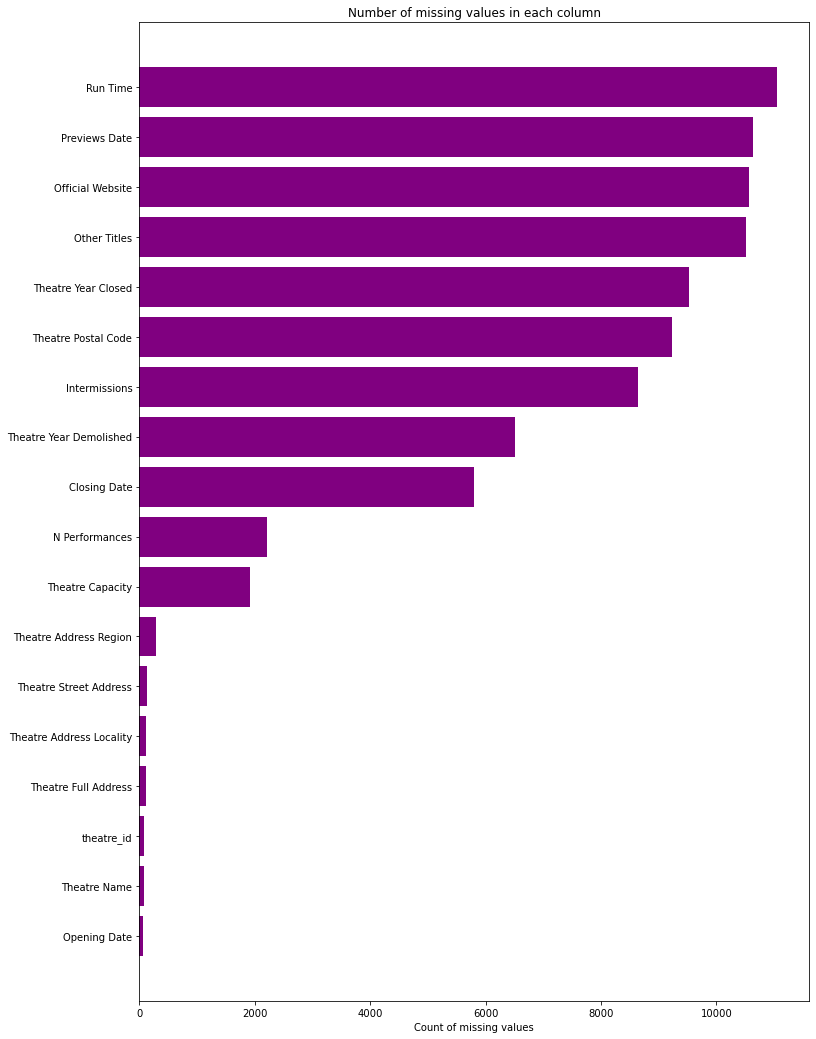

In [4]:
#Visualize missing null values
prepare.visualize_nulls(df)

> **How I dealt with nulls:**
    > - Columns with more than 50% of the data missing were dropped
    > - Observations with further missing data were dropped for this first iteration

In [5]:
#Clean the dataframe using the clean_bway function from the prepare module
df = prepare.prep_bway(df)

#View the shape of the prepared dataframe
table = [['Dataframe Name', '# of rows', '# of cols'], ['df', df.shape[0], df.shape[1]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═════════════╤═════════════╕
│ Dataframe Name   │   # of rows │   # of cols │
╞══════════════════╪═════════════╪═════════════╡
│ df               │        4549 │          26 │
╘══════════════════╧═════════════╧═════════════╛


**Preparation Takeaways:**<br>
    - In a future iteration, I would want to see if I can handle nulls in a different fashion to preserve more of the data.<br>
    - For this iteration, I left all outliers in and did not remove any.

---

# Data Exploration

**My approach towards exploration**<br>
   > Step 1: Define categorical variables, quantitative variables, continous target, categorical target<br>
   > Step 2: Univariate Exploration and document takeaways on distributions<br>
   > Step 3: Split data into train, validate, and test<br>
   > Step 4: Bivariate Exploration and document takeaways on feature interaction<br>
   > Step 5: Multivariate Exploration and document takeaways on feature interaction with target<br>
   > Step 6: Statistical Testing for questions raised<br>
   > Step 7: Exploration with clustering<br>
   > Step 8: Documented takeaways and plan for modeling

**Step 1: Define the variables and target**

In [6]:
#Create the categorical target by divding length of run into quantiles
df['run_class'] = pd.qcut(df.length_of_run, q=5, labels=['q1', 'q2', 'q3', 'q4', 'q5'])

In [7]:
#Define the variables and target for exploration
categorical_target = 'run_class'
continuous_target = 'length_of_run'
cat_vars = ['is_revival', 'Production Type_Concert',
       'Production Type_Original Production', 'Production Type_Premiere',
       'Production Type_Production', 'Production Type_Revised Production',
       'Production Type_Revival', 'Show Type_Ballet', 'Show Type_Dance',
       'Show Type_Musical', 'Show Type_One-Acts', 'Show Type_Opera Bouffe',
       'Show Type_Operetta', 'Show Type_Other', 'Show Type_Performance',
       'Show Type_Play', 'Show Type_Play with Music', 'Show Type_Solo',
       'Show Type_Vaudeville']

quant_vars = ['Year','N People', 'N Performers',
       'N Creative Team', 'theatre_id', 'Theatre Capacity', 'length_of_run']

---

**Step 2: Univariate Exploration:**

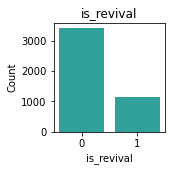

   is_revival  Count  Percent
0           0   3404    74.83
1           1   1145    25.17
_________________________________________________________________


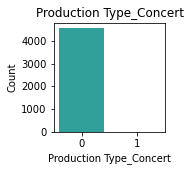

   Production Type_Concert  Count  Percent
0                        0   4547    99.96
1                        1      2     0.04
_________________________________________________________________


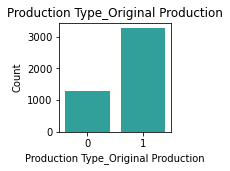

   Production Type_Original Production  Count  Percent
1                                    1   3266     71.8
0                                    0   1283     28.2
_________________________________________________________________


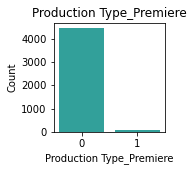

   Production Type_Premiere  Count  Percent
0                         0   4451    97.85
1                         1     98     2.15
_________________________________________________________________


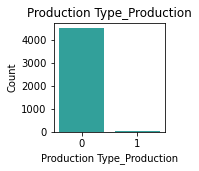

   Production Type_Production  Count  Percent
0                           0   4515    99.25
1                           1     34     0.75
_________________________________________________________________


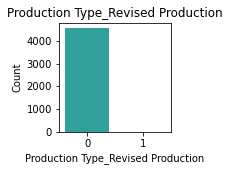

   Production Type_Revised Production  Count  Percent
0                                   0   4545    99.91
1                                   1      4     0.09
_________________________________________________________________


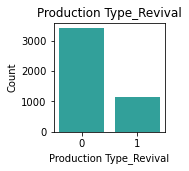

   Production Type_Revival  Count  Percent
0                        0   3404    74.83
1                        1   1145    25.17
_________________________________________________________________


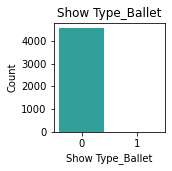

   Show Type_Ballet  Count  Percent
0                 0   4548    99.98
1                 1      1     0.02
_________________________________________________________________


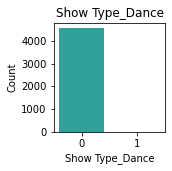

   Show Type_Dance  Count  Percent
0                0   4542    99.85
1                1      7     0.15
_________________________________________________________________


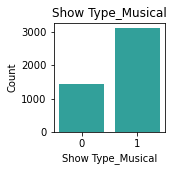

   Show Type_Musical  Count  Percent
0                  1   3106    68.28
1                  0   1443    31.72
_________________________________________________________________


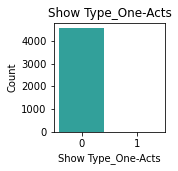

   Show Type_One-Acts  Count  Percent
0                   0   4548    99.98
1                   1      1     0.02
_________________________________________________________________


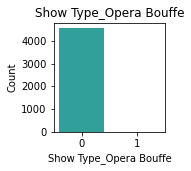

   Show Type_Opera Bouffe  Count  Percent
0                       0   4548    99.98
1                       1      1     0.02
_________________________________________________________________


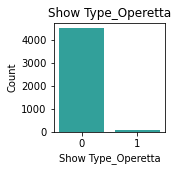

   Show Type_Operetta  Count  Percent
0                   0   4486    98.62
1                   1     63     1.38
_________________________________________________________________


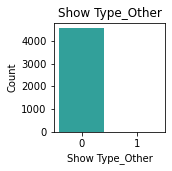

   Show Type_Other  Count  Percent
0                0   4548    99.98
1                1      1     0.02
_________________________________________________________________


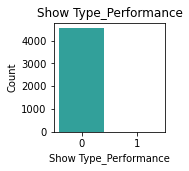

   Show Type_Performance  Count  Percent
0                      0   4541    99.82
1                      1      8     0.18
_________________________________________________________________


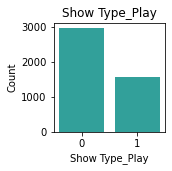

   Show Type_Play  Count  Percent
1               0   2970    65.29
0               1   1579    34.71
_________________________________________________________________


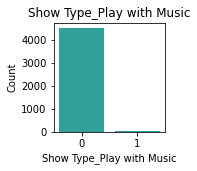

   Show Type_Play with Music  Count  Percent
0                          0   4522    99.41
1                          1     27     0.59
_________________________________________________________________


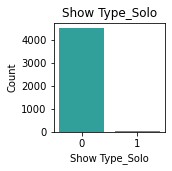

   Show Type_Solo  Count  Percent
0               0   4523    99.43
1               1     26     0.57
_________________________________________________________________


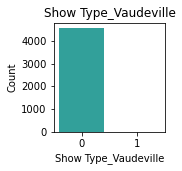

   Show Type_Vaudeville  Count  Percent
0                     0   4548    99.98
1                     1      1     0.02
_________________________________________________________________


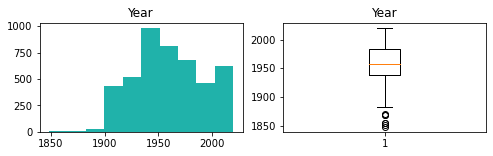

count    4549.000000
mean     1959.872719
std        32.051654
min      1848.000000
25%      1939.000000
50%      1958.000000
75%      1984.000000
max      2020.000000
Name: Year, dtype: float64


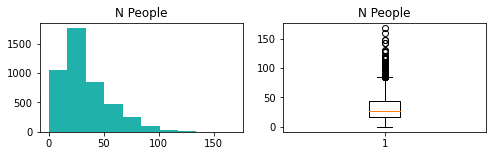

count    4549.000000
mean       32.774016
std        22.172128
min         0.000000
25%        17.000000
50%        27.000000
75%        44.000000
max       168.000000
Name: N People, dtype: float64


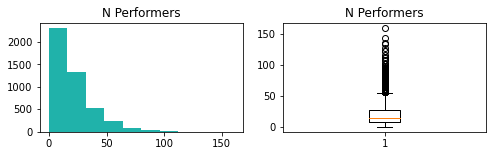

count    4549.000000
mean       20.237635
std        17.717440
min         0.000000
25%         8.000000
50%        15.000000
75%        27.000000
max       160.000000
Name: N Performers, dtype: float64


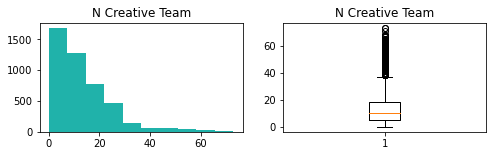

count    4549.000000
mean       13.363596
std        11.264301
min         0.000000
25%         5.000000
50%        10.000000
75%        18.000000
max        73.000000
Name: N Creative Team, dtype: float64


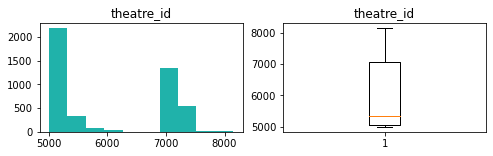

count    4549.000000
mean     6011.958452
std       993.364003
min      5000.000000
25%      5057.000000
50%      5334.000000
75%      7054.000000
max      8150.000000
Name: theatre_id, dtype: float64


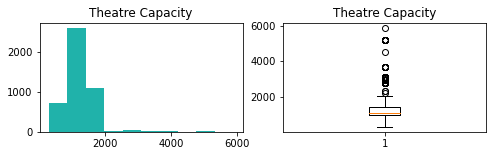

count    4549.000000
mean     1194.935590
std       479.068637
min       299.000000
25%       947.000000
50%      1093.000000
75%      1437.000000
max      5880.000000
Name: Theatre Capacity, dtype: float64


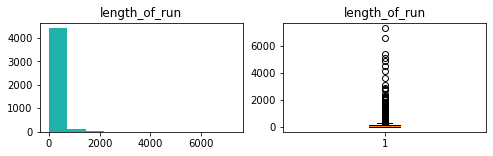

count    4549.000000
mean      135.562102
std       320.674066
min         0.000000
25%        13.000000
50%        51.000000
75%       124.000000
max      7293.000000
Name: length_of_run, dtype: float64


In [8]:
explore.explore_univariate(df, cat_vars, quant_vars)

> **Univariate Takeaways:**
> - Only 1/4 of the shows are revivals
> - Musicals dominate the show type categories...this is expected
> - Revival under production type + is production type...should I drop one?
> - Show type solo - is this duplicated with number of actors?

---

**Step 3: Split the data:**

In [9]:
#Split using split function from prepare module
partitions = prepare.split(df, 'length_of_run')

#Assign the train data set to the first partition returned by the split function
train = partitions[0]

#View the shape of the train dataframe
table = [['Dataframe Name', '# of rows', '# of cols'], ['train', train.shape[0], train.shape[1]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═════════════╤═════════════╕
│ Dataframe Name   │   # of rows │   # of cols │
╞══════════════════╪═════════════╪═════════════╡
│ train            │        2547 │          27 │
╘══════════════════╧═════════════╧═════════════╛


---

**Step 4: Bivariate Exploration:**

is_revival 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=631584.0, pvalue=0.24334262650803662)
         chi2       p-value  degrees of freedom
0  100.005672  9.809313e-21                   4

expected:
             0          1           2           3           4
0  375.818218  387.02552  372.829603  371.335296  395.991362
1  127.181782  130.97448  126.170397  125.664704  134.008638


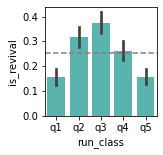


_____________________

Production Type_Concert 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=0.0, pvalue=0.0)
   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

expected:
        0      1      2      3      4
0  503.0  518.0  499.0  497.0  530.0


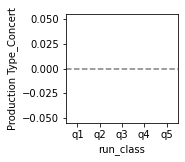


_____________________

Production Type_Original Production 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=661130.5, pvalue=0.9426571938913536)
         chi2       p-value  degrees of freedom
0  128.890545  6.724376e-27                   4

expected:
             0           1           2           3           4
0  142.980762  147.244601  141.843738  141.275226  150.655673
1  360.019238  370.755399  357.156262  355.724774  379.344327


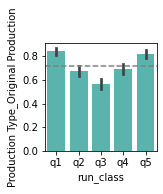


_____________________

Production Type_Premiere 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=53163.5, pvalue=0.0011824802617009386)
        chi2   p-value  degrees of freedom
0  27.499656  0.000016                   4

expected:
             0           1           2           3           4
0  491.743227  506.407538  487.832744  485.877503  518.138987
1   11.256773   11.592462   11.167256   11.122497   11.861013


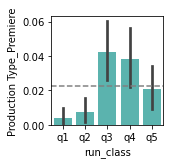


_____________________

Production Type_Production 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=24561.0, pvalue=0.5588596463430558)
        chi2   p-value  degrees of freedom
0  12.775751  0.012425                   4

expected:
             0           1           2           3           4
0  498.852768  513.729093  494.885748  492.902238  525.630153
1    4.147232    4.270907    4.114252    4.097762    4.369847


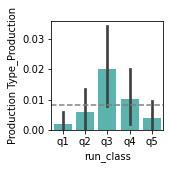


_____________________

Production Type_Revised Production 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=2286.0, pvalue=0.8036038086597812)
       chi2   p-value  degrees of freedom
0  3.116926  0.538452                   4

expected:
             0           1           2           3           4
0  502.605026  517.593247  498.608166  496.609737  529.583824
1    0.394974    0.406753    0.391834    0.390263    0.416176


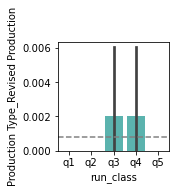


_____________________

Production Type_Revival 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=631584.0, pvalue=0.24334262650803662)
         chi2       p-value  degrees of freedom
0  100.005672  9.809313e-21                   4

expected:
             0          1           2           3           4
0  375.818218  387.02552  372.829603  371.335296  395.991362
1  127.181782  130.97448  126.170397  125.664704  134.008638


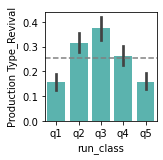


_____________________

Show Type_Ballet 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=759.0, pvalue=0.48487036352299206)
       chi2   p-value  degrees of freedom
0  4.126369  0.389174                   4

expected:
             0           1           2           3           4
0  502.802513  517.796623  498.804083  496.804868  529.791912
1    0.197487    0.203377    0.195917    0.195132    0.208088


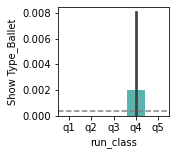


_____________________

Show Type_Dance 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=5294.5, pvalue=0.8874355473634385)
       chi2   p-value  degrees of freedom
0  3.479692  0.480973                   4

expected:
             0           1           2           3           4
0  502.210051  517.186494  498.216333  496.219474  529.167648
1    0.789949    0.813506    0.783667    0.780526    0.832352


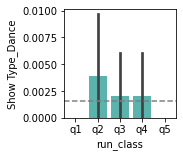


_____________________

Show Type_Musical 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=502074.0, pvalue=3.3166733577870585e-32)
         chi2       p-value  degrees of freedom
0  128.566319  7.888232e-27                   4

expected:
             0           1           2           3           4
0  341.652925  351.841382  338.936003  337.577542  359.992148
1  161.347075  166.158618  160.063997  159.422458  170.007852


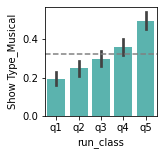


_____________________

Show Type_One-Acts 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=0.0, pvalue=0.0)
   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

expected:
        0      1      2      3      4
0  503.0  518.0  499.0  497.0  530.0


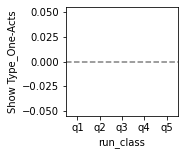


_____________________

Show Type_Opera Bouffe 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=0.0, pvalue=0.0)
   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

expected:
        0      1      2      3      4
0  503.0  518.0  499.0  497.0  530.0


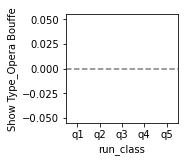


_____________________

Show Type_Operetta 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=53750.0, pvalue=0.6108450767896776)
        chi2   p-value  degrees of freedom
0  21.924854  0.000207                   4

expected:
             0           1           2           3           4
0  494.903023  509.661563  490.967413  488.999607  521.468394
1    8.096977    8.338437    8.032587    8.000393    8.531606


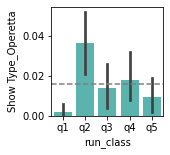


_____________________

Show Type_Other 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=517.5, pvalue=0.3044241425208387)
       chi2   p-value  degrees of freedom
0  3.807155  0.432733                   4

expected:
             0           1           2           3           4
0  502.802513  517.796623  498.804083  496.804868  529.791912
1    0.197487    0.203377    0.195917    0.195132    0.208088


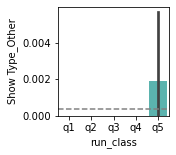


_____________________

Show Type_Performance 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=8987.0, pvalue=0.4484955274081044)
       chi2  p-value  degrees of freedom
0  9.296557   0.0541                   4

expected:
             0           1           2           3           4
0  501.815077  516.779741  497.824499  495.829211  528.751472
1    1.184923    1.220259    1.175501    1.170789    1.248528


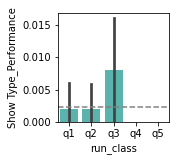


_____________________

Show Type_Play 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=947617.0, pvalue=2.5980961435665455e-31)
         chi2       p-value  degrees of freedom
0  126.982173  1.720566e-26                   4

expected:
             0           1           2           3           4
0  177.738516  183.038869  176.325088  175.618375  187.279152
1  325.261484  334.961131  322.674912  321.381625  342.720848


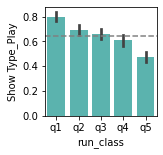


_____________________

Show Type_Play with Music 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=16101.0, pvalue=0.3090160443632708)
       chi2   p-value  degrees of freedom
0  7.144964  0.128423                   4

expected:
             0           1           2           3           4
0  500.037691  514.949352  496.061249  494.073027  526.878681
1    2.962309    3.050648    2.938751    2.926973    3.121319


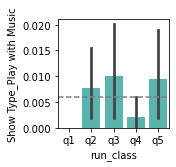


_____________________

Show Type_Solo 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=14899.5, pvalue=0.3021523258864742)
       chi2   p-value  degrees of freedom
0  3.868163  0.424142                   4

expected:
             0           1           2           3           4
0  500.235179  515.152729  496.257165  494.268159  527.086769
1    2.764821    2.847271    2.742835    2.731841    2.913231


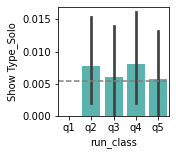


_____________________

Show Type_Vaudeville 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=2477.5, pvalue=0.10147458967944373)
       chi2   p-value  degrees of freedom
0  4.065214  0.397252                   4

expected:
             0           1           2           3           4
0  502.802513  517.796623  498.804083  496.804868  529.791912
1    0.197487    0.203377    0.195917    0.195132    0.208088


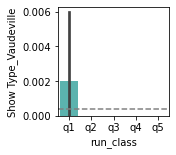


_____________________

Year 
____________________



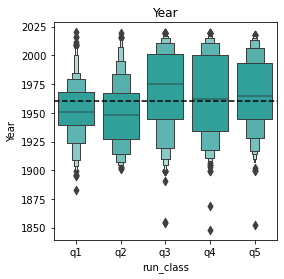

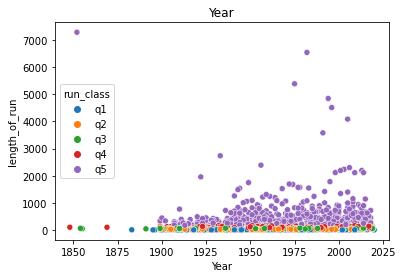

run_class           q1           q2           q3           q4           q5
count       503.000000   518.000000   499.000000   497.000000   530.000000
mean       1951.516899  1949.415058  1969.076152  1963.909457  1966.945283
std          24.532912    28.071605    35.622043    35.928719    30.483049
min        1883.000000  1901.000000  1854.000000  1848.000000  1852.000000
25%        1939.000000  1927.000000  1945.000000  1934.000000  1945.000000
50%        1951.000000  1948.000000  1975.000000  1962.000000  1965.000000
75%        1968.000000  1967.000000  2001.000000  2000.000000  1993.000000
max        2020.000000  2019.000000  2019.000000  2019.000000  2018.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.21883827997714292, pvalue=5.430759727508409e-29)

____________________

N People 
____________________



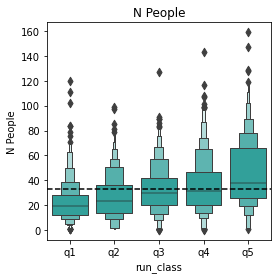

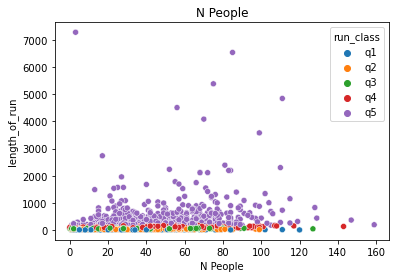

run_class          q1          q2          q3          q4          q5
count      503.000000  518.000000  499.000000  497.000000  530.000000
mean        22.634195   26.816602   32.791583   35.619718   45.737736
std         15.997802   17.896737   19.186483   22.326532   27.142784
min          1.000000    1.000000    0.000000    0.000000    1.000000
25%         12.000000   14.000000   20.000000   20.000000   26.000000
50%         19.000000   23.000000   30.000000   31.000000   38.000000
75%         28.000000   36.000000   42.000000   47.000000   65.750000
max        120.000000   99.000000  127.000000  143.000000  159.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.37671420288652635, pvalue=1.0970943636515481e-86)

____________________

N Performers 
____________________



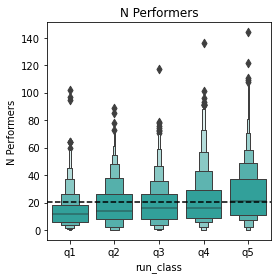

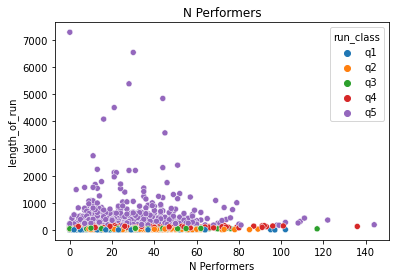

run_class          q1          q2          q3          q4          q5
count      503.000000  518.000000  499.000000  497.000000  530.000000
mean        14.896620   18.631274   19.108216   21.837022   26.096226
std         13.324081   15.840389   16.055386   19.460454   20.519993
min          0.000000    0.000000    0.000000    0.000000    0.000000
25%          6.000000    8.000000    8.000000    9.000000   11.000000
50%         12.000000   14.000000   16.000000   16.000000   21.000000
75%         18.000000   26.000000   26.500000   29.000000   37.000000
max        102.000000   89.000000  117.000000  136.000000  144.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.2204779452458138, pvalue=2.057805157889161e-29)

____________________

N Creative Team 
____________________



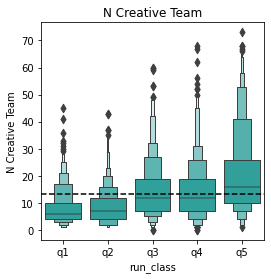

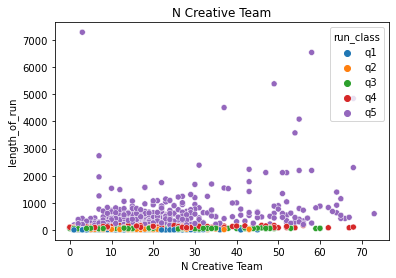

run_class          q1          q2          q3          q4          q5
count      503.000000  518.000000  499.000000  497.000000  530.000000
mean         8.258449    8.799228   14.561122   14.605634   20.896226
std          6.717166    6.725787   10.648348   11.041226   15.072433
min          1.000000    1.000000    0.000000    0.000000    1.000000
25%          4.000000    4.000000    7.000000    7.000000   10.000000
50%          6.000000    7.000000   12.000000   12.000000   16.000000
75%         10.000000   12.000000   19.000000   19.000000   26.000000
max         45.000000   43.000000   60.000000   68.000000   73.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.4355912488472926, pvalue=1.9229935838013332e-118)

____________________

theatre_id 
____________________



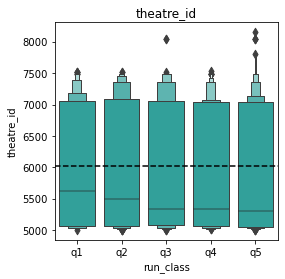

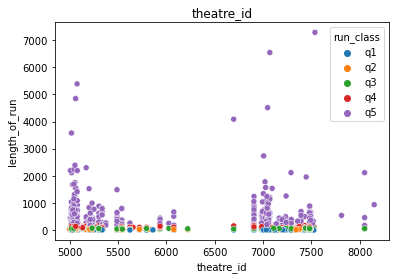

run_class           q1           q2           q3           q4           q5
count       503.000000   518.000000   499.000000   497.000000   530.000000
mean       6098.330020  6066.328185  6067.505010  5956.251509  5915.839623
std         995.966558  1011.258396  1017.290273   952.287621   985.884073
min        5003.000000  5000.000000  5000.000000  5013.000000  5007.000000
25%        5057.000000  5063.750000  5077.000000  5057.000000  5047.000000
50%        5622.000000  5488.000000  5334.000000  5334.000000  5300.000000
75%        7059.000000  7094.000000  7059.000000  7040.000000  7040.000000
max        7524.000000  7524.000000  8051.000000  7528.000000  8150.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=-0.09442683736183036, pvalue=1.8074053537301035e-06)

____________________

Theatre Capacity 
____________________



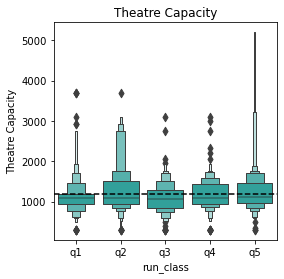

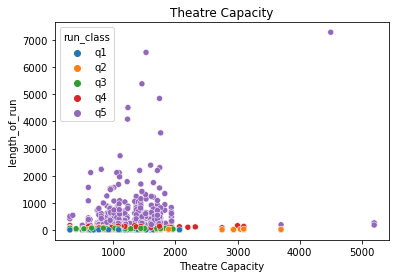

run_class           q1           q2           q3           q4           q5
count       503.000000   518.000000   499.000000   497.000000   530.000000
mean       1123.256461  1297.592664  1089.871743  1173.800805  1278.915094
std         420.783148   558.099062   366.377249   348.880275   588.673009
min         300.000000   300.000000   300.000000   300.000000   299.000000
25%         945.000000   948.500000   840.000000   954.000000   970.000000
50%        1084.000000  1100.000000  1080.000000  1094.000000  1108.500000
75%        1186.000000  1503.750000  1279.000000  1437.000000  1460.000000
max        3700.000000  3700.000000  3100.000000  3100.000000  5200.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.08908439714361448, pvalue=6.711390389008903e-06)

____________________

length_of_run 
____________________



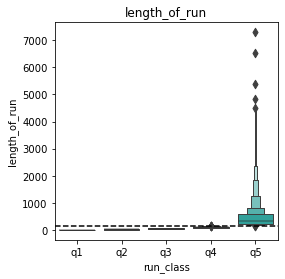

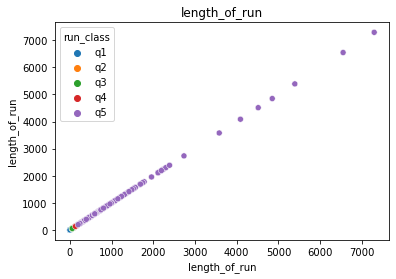

run_class          q1          q2          q3          q4           q5
count      503.000000  518.000000  499.000000  497.000000   530.000000
mean         3.546720   20.907336   52.376754  109.331992   531.279245
std          3.186329    7.129033   11.024177   25.719024   674.832426
min          0.000000   11.000000   34.000000   74.000000   166.000000
25%          0.000000   14.000000   42.000000   88.000000   229.000000
50%          3.000000   19.000000   52.000000  103.000000   343.500000
75%          5.000000   26.000000   61.000000  129.000000   591.000000
max         10.000000   33.000000   73.000000  165.000000  7293.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=1.0, pvalue=0.0)

____________________



In [10]:
#Re-assign cat_vars to binary_vars for the bivariate exploration function
binary_vars = cat_vars

#Explore bivariate using bivariate function from the explore module
explore.explore_bivariate(train, categorical_target, continuous_target, binary_vars, quant_vars)

> **Bivariate Takeaways:**
> - is_revival is normally distributed by run class
> - Original productions either flop immediately or do really well it seems visually, but the pvalue is too high
> - Premiere may be a good feature it seems for predicting run length
> - Not much for production or revised production
> - Ballet in q4 only...how many different ballets are there in this data set?
> - Dance is in the middle...no super long runs, but also no super short runs
> - Musicals skew towards longer runs...as expected
> - Shows classfied as type "Other" seem to run longer which is interesting...is it because the category is high risk that producers only take it on when they have reason to believe it will be a huge success?
> - Plays have shorter run lengths...again, no  surprise there
> - But plays with music do better...may want to make sure I keep those categories disticnt
> - Not much said for solo
> - Vaudevile is short runs...probably correlated with when the show premiered and run times were shorter?
> - Looks like there is a relationship between when a show premiered and how long it runs
> - The number of performers seems to have a relationship with length of run
> - Creative team and the number of people on it is definitely correlated
> - Looks like some venues are more successful
> - Capacity is correlated with success

---

**Step 5: Multivariate Exploration**

<AxesSubplot:>

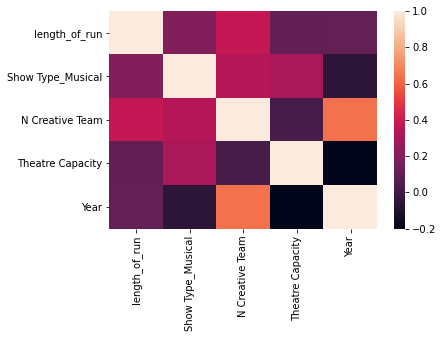

In [11]:
#Visualize a heatmap for selected features and target
sns.heatmap(train[['length_of_run','Show Type_Musical','N Creative Team','Theatre Capacity','Year']].corr())

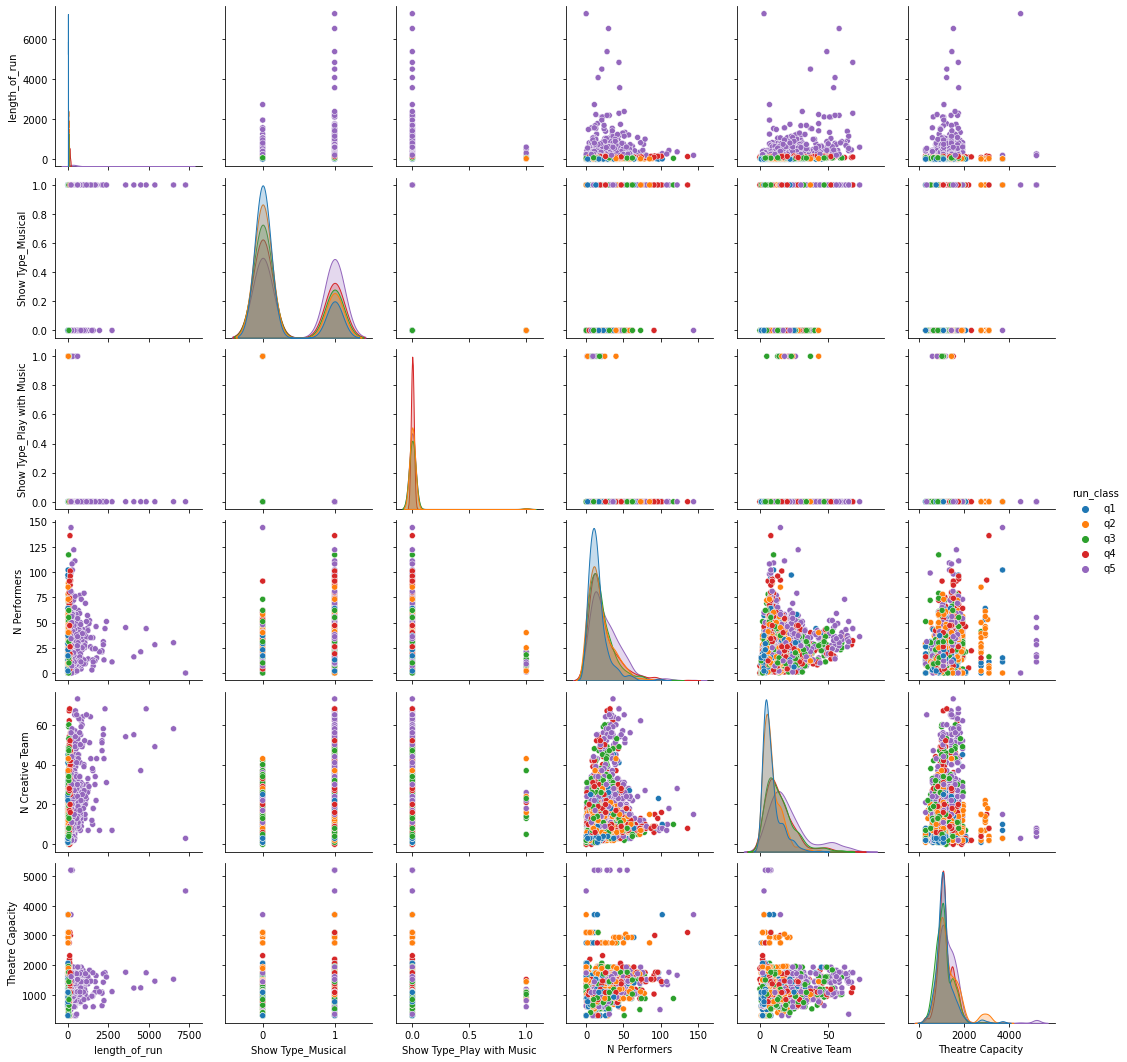

In [12]:
#Use a pairplot to further explore feature interaction with the target (length of run)
sns.pairplot(train[['length_of_run', 'run_class','Show Type_Musical', 'Show Type_Play with Music',
      'N Performers','N Creative Team','Theatre Capacity']], hue='run_class')

> **Multivariate Takeaways:**<br>
> - Visually, it is hard to gather any significant takeways. Need to do some statistical testing

---

**Step 6: Statistical Testing**

> **Question 1: Are certain types of shows more likely to have longer run lengths than other types of shows?**

In [13]:
# I ran a mann-whitney u test to analyze this due to the fact that logerror is not normally distributed<br>

#Hypotheses
Ho = "Musicals do not have a different length_of_run mean than shows not classfied as musicals."
Ha = "Muscials have a greater length_of_run mean than non-musical shows"

#Set the confidence interval for testing
confidence_interval = .95
a = 1 - confidence_interval

#Define the two samples where x1 is musical and x2 is all shows that are not musicals
x1 = train[train['Show Type_Musical'] == 1].length_of_run
x2 = train[train['Show Type_Musical'] != 1].length_of_run

#Run the test
t, p = stats.mannwhitneyu(x1, x2, alternative='greater')

#print results
print(f'The mannwhitneyu statistic is:{t} and the p-value is {p}')
print('----------------')
if p < a:
    print('Reject the null hypothesis.')
    print('---')
    print(f'Move forward with the understanding that {Ha}')
else:
    print('Fail to reject the null hypothesis.')
    print('---')
    print(f'Move forward with the understanding that {Ho}')


The mannwhitneyu statistic is:911336.0 and the p-value is 1.6583366788934816e-32
----------------
Reject the null hypothesis.
---
Move forward with the understanding that Muscials have a greater length_of_run mean than non-musical shows


> **Question 2: Is there a significant correlation between the number of creative team members on a show and the length of run for that show?**

In [14]:
#Hypotheses
Ho = "The number of creative team members on a show does not relate to how long the show will run."
Ha = "The number of creative team members on a show relates to how long a show runs."

#Create the pearson correlation coefficient t-test keeping a confidence interval of .95
corr, p = stats.pearsonr(train['N Creative Team'], train.length_of_run)

#print results
print(f'The Pearson Correlation statistic is:{corr} and the p-value is {p}')
print('----------------')
if p < a:
    print('Reject the null hypothesis.') 
    print('---')    
    print(f'Move forward with the understanding that {Ha}')
else:
    print(f'Fail to reject the null hypothesis. Move forward with the understanding that {Ho}')


The Pearson Correlation statistic is:0.3786622406218869 and the p-value is 1.2288544922904692e-87
----------------
Reject the null hypothesis.
---
Move forward with the understanding that The number of creative team members on a show relates to how long a show runs.


> **Stats Testing Takeaways:**<br>
    > - Whether a show is a musical or not is going to be a good driver of length_of_run<br>
    > - The number of people involved on the creative team is also a good driver for length_of_run

---

**Step 7: Exploration with Clustering**

In [15]:
# define the variables that need scaling
scaled_vars = ['Year', 'N People', 'N Performers',
       'N Creative Team', 'theatre_id', 'Theatre Capacity']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
X_validate = X[1]
X_test = X[2]

scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])
scaler = MinMaxScaler(copy=True).fit(X_validate[scaled_vars])
scaler = MinMaxScaler(copy=True).fit(X_test[scaled_vars])

def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])
    
#Set X_train to X[0] (Partitions[1] = X_train = X[0])
X_train = X[0]
X_validate = X[1]
X_test = X[2]

**Cluster on Year and 'N Creative Team'**

In [16]:
# define independent variables for k-means
X = X_train[['Year', 'N Creative Team']]

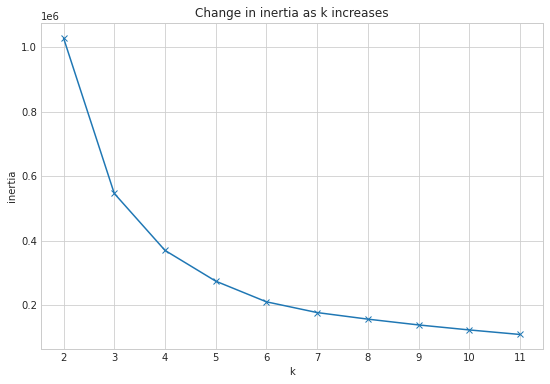

In [17]:
# Plot inertia to determine k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

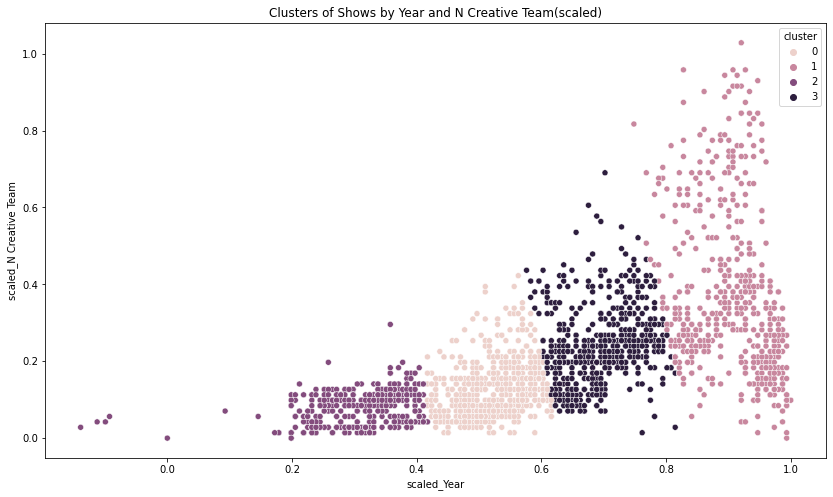

In [18]:
#define the thing
kmeans = KMeans(n_clusters=4)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

# make a new column names cluster in X_train and X[0] dataframe
X_train['cluster'] = kmeans.predict(X)

# Cluster Centers aka centroids - THE OUTPUT IS SCALED 
kmeans.cluster_centers_

# Make a dataframe of the Centroids for visualization
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

#Plot the clusters and centroids
plt.figure(figsize=(14,8))

sns.scatterplot(x="scaled_Year", y="scaled_N Creative Team", data=X_train, hue='cluster')

# plot cluster centers (centroids)
#centroids_scaled.plot.scatter(x="scaled_Year", y="scaled_N Creative Team", ax=plt.gca(), color='k', alpha = 0.3, s = 200, marker = 'o', label = 'centroids_scaled')

plt.title('Clusters of Shows by Year and N Creative Team(scaled)')
plt.show()

In [19]:
X_train.drop(columns={'cluster'}, inplace=True)

> **Clustering Takeaways:**<br>
    - Strong visual showing that more modern and contemmporary productions have more creative team members involved with working on those productions.<br>
    - Is this due to the fact that the stakes are higher now to mount a production than earlier in the history of Broadway?<br>
    - New technologies used in productions, like video and scenic design mapping as just two examples, also may contribute to the need for specialized creative team members, contributing to the increase in those roles for a prodction.

---

**Step 8: Documented Takeaways from Exploration and Modeling Plan**
> **Features Driving Target:**
    > - Show type, specifically if the show is a musical or not
    > - Number of people on the creative team
    
> **Modeling Plan:**
    > - Start with linear regression modeling for predicting length_of_run.
    > - Use select K Best to determine the best features and confirm the features identified during exploration will be utilized.
    > - Depending on results and time, I may also want to utiize the categorical target (binned length of run) and use classification algorithms. 

# Modeling

**Note:**  
Check out my explore_workbook in this repo for additional modeling that I conducted. This notebook below will highlight the best performing model from the modeling completed in that workbook.

In [20]:
#Define the other dataframes from partitions
y_train = partitions[4]
y_validate = partitions[5] 
y_test = partitions[6]

**Select K Best for Feature Selection**

In [21]:
#Create the kbest object
f_selector = SelectKBest(f_regression, k=5)

#Fit the kbest oject to the training data
f_selector = f_selector.fit(X_train[['is_revival', 'Production Type_Concert',
       'Production Type_Original Production', 'Production Type_Premiere',
       'Production Type_Production', 'Production Type_Revised Production',
       'Production Type_Revival', 'Show Type_Ballet', 'Show Type_Dance',
       'Show Type_Musical', 'Show Type_One-Acts', 'Show Type_Opera Bouffe',
       'Show Type_Operetta', 'Show Type_Other', 'Show Type_Performance',
       'Show Type_Play', 'Show Type_Play with Music', 'Show Type_Solo',
       'Show Type_Vaudeville', 'scaled_Year', 'scaled_N People',
       'scaled_N Performers', 'scaled_N Creative Team', 'scaled_theatre_id',
       'scaled_Theatre Capacity']], y_train)

#Return top 5 features

f_support = f_selector.get_support()
f_feature = X_train[['is_revival', 'Production Type_Concert',
       'Production Type_Original Production', 'Production Type_Premiere',
       'Production Type_Production', 'Production Type_Revised Production',
       'Production Type_Revival', 'Show Type_Ballet', 'Show Type_Dance',
       'Show Type_Musical', 'Show Type_One-Acts', 'Show Type_Opera Bouffe',
       'Show Type_Operetta', 'Show Type_Other', 'Show Type_Performance',
       'Show Type_Play', 'Show Type_Play with Music', 'Show Type_Solo',
       'Show Type_Vaudeville', 'scaled_Year', 'scaled_N People',
       'scaled_N Performers', 'scaled_N Creative Team', 'scaled_theatre_id',
       'scaled_Theatre Capacity']].iloc[:, f_support].columns.tolist()

print(f'Select KBest returned the top 5 features for predicting length_of_run are: {f_feature}')

Select KBest returned the top 5 features for predicting length_of_run are: ['Show Type_Musical', 'Show Type_Play', 'scaled_N People', 'scaled_N Performers', 'scaled_N Creative Team']


---

**Baseline Model**

In [22]:
# Predict length of run with mean ==> Determined this is a more accurate predictior than the median
yhat_baseline = y_train['length_of_run'].mean()
y_train['yhat_baseline_mean'] = yhat_baseline

#Evaluate the baseline model using the mean
mean_baseline_stats = pd.DataFrame([evaluate.baseline_mean_errors(y_train.length_of_run)])
mean_baseline_stats

,sse,mse,rmse
0,3.433513e+08,134806.181809,367.159614


> **Baseline Takeaways:**<br>
> - The goal is to build a model that reduces the prediction length of run errors by 367 days

---

**Generalized Linear Model Using Tweedie Regressor**

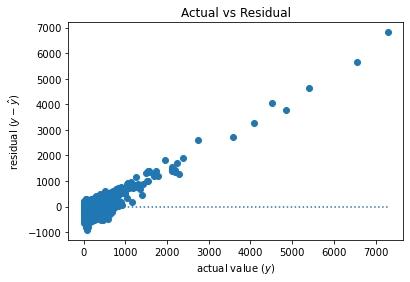

,sse,ess,tss,mse,rmse,r^2
0,2.778172e+08,6.709988e+07,3.433513e+08,109076.248329,330.266935,0.195426


In [23]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data (scaled features where necessary). I must specify the column in y_train, 
# since I have converted it to a dataframe from a series! 
glm.fit(X_train[['is_revival', 'Production Type_Concert',
       'Production Type_Original Production', 'Production Type_Premiere',
       'Production Type_Production', 'Production Type_Revised Production',
       'Production Type_Revival', 'Show Type_Ballet', 'Show Type_Dance',
       'Show Type_Musical', 'Show Type_One-Acts', 'Show Type_Opera Bouffe',
       'Show Type_Operetta', 'Show Type_Other', 'Show Type_Performance',
       'Show Type_Play', 'Show Type_Play with Music', 'Show Type_Solo',
       'Show Type_Vaudeville', 'scaled_Year', 'scaled_N People',
       'scaled_N Performers', 'scaled_N Creative Team', 'scaled_theatre_id',
       'scaled_Theatre Capacity']], y_train.length_of_run)

# predict train
y_train['yhat_glm'] = glm.predict(X_train[['is_revival', 'Production Type_Concert',
       'Production Type_Original Production', 'Production Type_Premiere',
       'Production Type_Production', 'Production Type_Revised Production',
       'Production Type_Revival', 'Show Type_Ballet', 'Show Type_Dance',
       'Show Type_Musical', 'Show Type_One-Acts', 'Show Type_Opera Bouffe',
       'Show Type_Operetta', 'Show Type_Other', 'Show Type_Performance',
       'Show Type_Play', 'Show Type_Play with Music', 'Show Type_Solo',
       'Show Type_Vaudeville', 'scaled_Year', 'scaled_N People',
       'scaled_N Performers', 'scaled_N Creative Team', 'scaled_theatre_id',
       'scaled_Theatre Capacity']])

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.length_of_run, y_train.yhat_glm)

#How does the GLM model perform on in-sample data?
pd.DataFrame(evaluate.regression_errors(y_train.length_of_run, y_train.yhat_glm)).T

> **GLM In-sample Performance Takeaway:**
> - The GLM model outperforms the baseline model by reducing the error in predicting the number of days a show runs by 10%
> - Proceed to see how the GLM model performs on the Validate Data Set

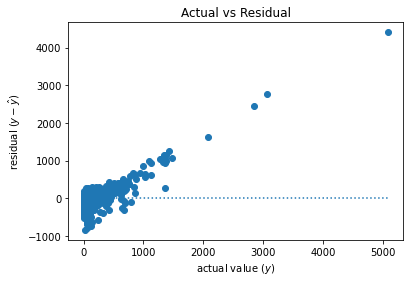

,sse,ess,tss,mse,rmse,r^2
0,7.890212e+07,2.527368e+07,9.001692e+07,72254.68542,268.802317,0.280766


In [24]:
# predict validate
y_validate['yhat_glm'] = glm.predict(X_validate[['is_revival', 'Production Type_Concert',
       'Production Type_Original Production', 'Production Type_Premiere',
       'Production Type_Production', 'Production Type_Revised Production',
       'Production Type_Revival', 'Show Type_Ballet', 'Show Type_Dance',
       'Show Type_Musical', 'Show Type_One-Acts', 'Show Type_Opera Bouffe',
       'Show Type_Operetta', 'Show Type_Other', 'Show Type_Performance',
       'Show Type_Play', 'Show Type_Play with Music', 'Show Type_Solo',
       'Show Type_Vaudeville', 'scaled_Year', 'scaled_N People',
       'scaled_N Performers', 'scaled_N Creative Team', 'scaled_theatre_id',
       'scaled_Theatre Capacity']])

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_validate.length_of_run, y_validate.yhat_glm)

#How does the GLM model perform on in-sample data?
pd.DataFrame(evaluate.regression_errors(y_validate.length_of_run, y_validate.yhat_glm)).T

> **GLM Validate Performance Takeaway:**
    > - Error reduction for the number of days a show will run by 27%

**Evaluate GLM Model on Out of Sample Data**

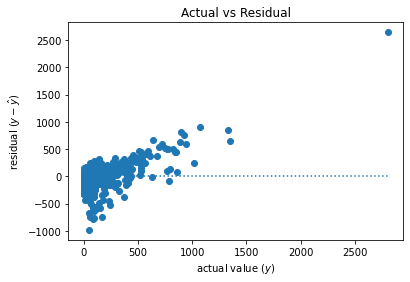

,sse,ess,tss,mse,rmse,r^2
0,3.668300e+07,2.226010e+07,3.336243e+07,40310.992361,200.775976,0.667221


In [25]:
# predict test
y_test['yhat_glm'] = glm.predict(X_test[['is_revival', 'Production Type_Concert',
       'Production Type_Original Production', 'Production Type_Premiere',
       'Production Type_Production', 'Production Type_Revised Production',
       'Production Type_Revival', 'Show Type_Ballet', 'Show Type_Dance',
       'Show Type_Musical', 'Show Type_One-Acts', 'Show Type_Opera Bouffe',
       'Show Type_Operetta', 'Show Type_Other', 'Show Type_Performance',
       'Show Type_Play', 'Show Type_Play with Music', 'Show Type_Solo',
       'Show Type_Vaudeville', 'scaled_Year', 'scaled_N People',
       'scaled_N Performers', 'scaled_N Creative Team', 'scaled_theatre_id',
       'scaled_Theatre Capacity']])

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_test.length_of_run, y_test.yhat_glm)

#How does the GLM model perform on in-sample data?
pd.DataFrame(evaluate.regression_errors(y_test.length_of_run, y_test.yhat_glm)).T

> **GLM Out-of-Sample Performance Takeaway:**
    > - The GLM model reduced error for the predicted number of days a show will run by 46% 
    > - 67% of the variance in the predicted error can be explained by the features driving the target
    > - The GLM model significantly improves upon the baseline model. This model can be utilzed to predict how long a show will run until a better model is developed or new data emerges resulting in a decreased model performance.

---

# Conclusions and Next Steps

> **Model Performance**
    > - The GLM model reduces error for the predicted number of days a show will run by 46%
    > - This model is better than no model at all and can be utilized for helping producers to project profit for a Broadway show.

> **Next Steps**
    > - Modifying preparation tactics and cleaning tactics to preserve more data and features
    > - Acquiring more data for features that may help predicting run length such as:
        > - Ticket pricing
        > - Is there a recognizable star performing in the show
        > - Caliber of the creative team (Tony winners)
        > - How much money was spent on marketing
        > - What is the average audience count for the show during previews
    > - Transform target into a categorical target for length of run
        > - Use a classficatin algorithm to predict the length of run class